# Development: Train 3-Category Classifier
Use the latest and greatest model structures, parameters, workflow (ie class weighting, learning fast & slow, etc) to train a 3-category classifier using only the non-road training samples.

This is the latest version as of the start of Phase IV, meant to leverage the previous changes in order to utilize the `fit_generator`.

Date: 2019-02-01  
Author: Peter Kerins  

## Preparation

### Import statements
(may be over-inclusive)

In [41]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt

import pandas as pd

import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from tensorflow.keras.models import load_model
import math
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections
from pprint import pprint

import descarteslabs as dl
# print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
sys.path.append(ULU_REPO)
print(sys.path)

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_chips
import util_training
import util_network
import util_scoring
from catalog_generator import CatalogGenerator

['/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python36.zip', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/lib-dynload', '', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Taufiq.Rashid/UrbanLandUse/utils', '/home/Taufiq.Rashid/UrbanLandUse', '/home/Taufiq.Rashid/UrbanLandUse/utils', '/home/Taufiq.Rashid/UrbanLandUse']


### Set key variables

In [42]:
data_root='/data/phase_iv/'

tile_resolution = 5
tile_size = 256
tile_pad = 32
resolution=tile_resolution  # Lx:15 S2:10

processing_level = None
source = 's2'
#image_suffix = 'E'

s2_bands=['blue','green','red','nir','swir1','swir2','alpha']; s2_suffix='BGRNS1S2A'  # S2, Lx

s1_bands=['vv','vh']; s1_suffix='VVVH'  

resampling='bilinear'
processing = None

label_suffix = 'aue'
label_lot = '0'

# can do much more sophisticated filtering than this, but fine for demonstration
place_images = {}
place_images['hindupur']=['U']#['U', 'V', 'W', 'X', 'Y', 'Z']
# place_images['singrauli']=['O','P','Q','R','S','T','U']
# place_images['vijayawada']=['H','I']
# place_images['jaipur']=['T','U','W','X','Y','Z']
# place_images['hyderabad']=['P','Q','R','S','T','U']
# place_images['sitapur']=['Q','R','T','U','V']
# place_images['kanpur']=['AH', 'AK', 'AL', 'AM', 'AN']
# place_images['belgaum']=['P','Q','R','S','T']
# place_images['parbhani']=['T','V','W','X','Y','Z']
# place_images['pune']=['P', 'Q', 'T', 'U', 'S']
# place_images['ahmedabad']= ['Z', 'V', 'W', 'X', 'Y', 'AA']
# place_images['malegaon']=  ['V', 'W', 'X', 'Y', 'Z']
# place_images['kolkata'] =  ['M','N','O','P','Q','R']
# place_images['mumbai']=['P','Q','R','S','U','V']


In [3]:
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

cats_map = {}
cats_map[0] = 0
cats_map[1] = 1
cats_map[2] = 2
cats_map[3] = 2
cats_map[4] = 2
cats_map[5] = 3

### Specify training data & training parameters

In [4]:
window = 17

# bands stuff outdated! needs to be reconciled with catalog filtering
# will ignore for the moment since this is a bigger fix...
# haven't done any examples yet incorporating additional chips beyond s2
# into construction of a training sample
bands_vir=s2_bands[:-1]
bands_sar=None
bands_ndvi=None
bands_ndbi=None
bands_osm=None

# this can get updated when cloudmasking is added
haze_removal = False

epochs = 500 # this is fine, if irrelevant
batch_size = 128
balancing = None

In [5]:
# needs to be updated completely; bands stuff doesn't make sense right now
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print(stack_label, feature_count)

vir 6


### Specify data of interest
Load and manipulate the catalog to specify which samples are of interest for this training.

### Create new dataset for training

In [6]:
df = util_chips.load_catalog()
print(len(df.index))

39281620


In [7]:
mask = pd.Series(data=np.zeros(len(df.index),dtype='uint8'), index=range(len(df)), dtype='uint8')

for place,image_list in place_images.items():
    for image in image_list:
        mask |= (df['city']==place) & (df['image']==image)

# straight away remove road samples
mask &= (df['lulc']!=6)

# filter others according to specifications
mask &= (df['gt_type']==label_suffix)
mask &= (df['gt_lot']==int(label_lot))
mask &= (df['source']==source)
mask &= (df['resolution']==int(resolution))
mask &= (df['resampling']==resampling)
mask &= (df['processing']==str(processing).lower())

print(np.sum(mask))

107891


In [8]:
#here for example we will just exclude all roads samples
df = df[mask]
df.reset_index(drop=True,inplace=True)
len(df)


107891

In [9]:
place_locales_paths = [
                       '/data/phase_iv/models/3cat_Hin_U-Z_place_locales.pkl'       ,
                       ]
# place_locales_paths = ['/data/phase_iv/models/3cat_Ahm_V-AA_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Bel_P-T_place_locales.pkl'       ,
#                        '/data/phase_iv/models/3cat_Hin_U-Z_place_locales.pkl'       ,
#                        '/data/phase_iv/models/3cat_Hyd_P-U_place_locales.pkl'       ,
#                        '/data/phase_iv/models/3cat_Jai_T-U+W-Z_place_locales.pkl'   ,
#                        '/data/phase_iv/models/3cat_Kan_AH+AK-AN_place_locales.pkl'  ,
#                        '/data/phase_iv/models/3cat_Mal_V-Z_place_locales.pkl'       ,
#                        '/data/phase_iv/models/3cat_Par_T+V-Z_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Pun_P-Q+S-U_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Sin_O-U_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Sit_Q-R+T-V_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Vij_H-I_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Kol_M-R_place_locales.pkl',
#                        '/data/phase_iv/models/3cat_Mum_P-V_place_locales.pkl'
#                        ]

In [10]:
combined_place_locales = {}
print(combined_place_locales)
for place_locales_filename in place_locales_paths:
    with open(place_locales_filename, "rb") as f:
        place_locales = pickle.load(f,encoding='latin1')
    combined_place_locales.update(place_locales)
print(combined_place_locales)

{}
{'hindupur': (array([ 0, 29, 28, 18, 17, 16, 15, 27,  9, 13, 20, 12, 24, 25,  3,  1,  5,
       11,  4, 26,  2]), array([ 6, 10,  7, 30,  8, 21, 22, 14, 19, 23]))}


In [11]:
df_t, df_v = util_chips.mask_locales(df, combined_place_locales)
print(len(df_t), len(df_v))

73026 34865


In [ ]:
# save the datasets for future use
%time df_t.to_csv(data_root+'models/'+'all_city_dataset-train.csv',index=False)
%time df_v.to_csv(data_root+'models/'+'all_city_dataset-valid.csv',index=False)

### Alternatively load previously saved dataset 

In [ ]:
# Set your input validation dataset file here
training_data = data_root+'models/'+'all_city_dataset-train.csv'

# Read the validation dataset to a Pandas Dataframe
df_t = pd.read_csv(input_filename, encoding='utf8')

# Set your input validation dataset file here
validation_data = data_root+'models/'+'all_city_dataset-valid.csv'

# Read the validation dataset to a Pandas Dataframe
df_v = pd.read_csv(input_filename, encoding='utf8')

print(len(df_t), len(df_v))

## Training

### Build loss function

#### Inspect dataframes for consistency

In [12]:
print(util_training.calc_category_counts(df_t,remapping=None), len(df_t))
print(util_training.calc_category_counts(df_v,remapping=None), len(df_v))
print()
print(util_training.calc_category_counts(df,remapping=None), len(df))

{0: 35976, 3: 25601, 1: 6520, 2: 4929} 73026
{0: 19104, 3: 8442, 1: 5395, 2: 1616, 5: 304, 4: 4} 34865

{0: 55080, 3: 34043, 1: 11915, 2: 6545, 5: 304, 4: 4} 107891


#### Generate class weighting information

In [13]:
df2=pd.concat([df_t,df_v])

In [14]:
category_weights =  util_training.generate_category_weights(df2,remapping='standard',log=False,mu=1.0,max_score=None)

In [15]:
category_weights

{0: 1.0, 1: 4.622744439781788, 2: 1.346830985915493}

In [16]:
print(category_weights.items())
weights = list(zip(*category_weights.items()))[1]
print(weights)

dict_items([(0, 1.0), (1, 4.622744439781788), (2, 1.346830985915493)])
(1.0, 4.622744439781788, 1.346830985915493)


#### Use weights to make weighted categorical crossentropy loss function

In [17]:
loss = util_training.make_loss_function_wcc(weights)

### Build convolutional neural network

#### Name and briefly describe model

In [18]:
model_id = '3cat_hyd_test'
notes = 'testing noteboook for py3'

In [ ]:
# print("DEFAULT:",K.image_data_format())
# K.set_image_data_format('channels_first')
# print("UPDATED:",K.image_data_format())

#### Create actual model

In [23]:
#hardcoded params
network=util_network.build_xmodel(input_shape=(17,17,6),output_nodes=3,input_conv_block=True)
util_network.compile_network(network, loss, LR=0.001)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 17, 17, 6)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 17, 17, 32)   1760        input_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 17, 17, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 17, 17, 32)   9248        activation_7[0][0]               
__________________________________________________________________________________________________
activation

---

### Train model fast

#### Create generators to provide training samples

In [24]:
generator_t = CatalogGenerator(df_t,remapping='3cat',look_window=window,batch_size=batch_size,one_hot=3)
generator_v = CatalogGenerator(df_v,remapping='3cat',look_window=window,batch_size=batch_size,one_hot=3)

#### Create callback functions for training

In [25]:
weights_label='weights_fast'
callbacks, weights_path = util_training.create_callbacks(data_root, model_id, weights_label=weights_label, patience=2)

#### Conduct training using `fit_generator` and visualize progress

Epoch 1/500
571/571 [==============================] - 112s 195ms/step - loss: 1.1040 - acc: 0.7243 - val_loss: 5.9329 - val_acc: 0.5518
Epoch 2/500
571/571 [==============================] - 44s 77ms/step - loss: 0.7769 - acc: 0.7884 - val_loss: 3.4204 - val_acc: 0.6763
Epoch 3/500
571/571 [==============================] - 59s 104ms/step - loss: 0.6285 - acc: 0.8238 - val_loss: 4.5343 - val_acc: 0.6618
Epoch 4/500
571/571 [==============================] - 32s 55ms/step - loss: 0.5246 - acc: 0.8514 - val_loss: 3.9528 - val_acc: 0.6607


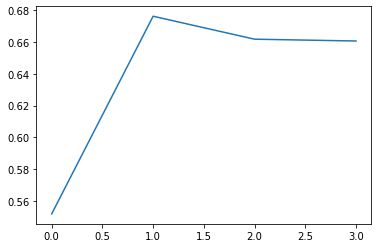

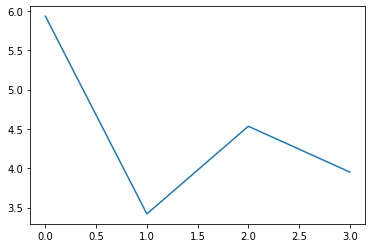

In [26]:
# train fast
#history_fast = network.fit(X_train, Y_t_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_cat), shuffle=True,callbacks=callbacks)
#docs: fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None,
                    #class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
history_fast = network.fit_generator(generator_t, epochs=epochs, callbacks=callbacks, steps_per_epoch=generator_t.steps,
                                    validation_data=generator_v, validation_steps=generator_v.steps,
                                    shuffle=True,use_multiprocessing=True,max_queue_size=40,workers=64,)

plt.plot(history_fast.history['val_acc'])
plt.show()
plt.plot(history_fast.history['val_loss'])
plt.show()

---

### Rebuild model and train slow

In [28]:
#hardcoded params
network=util_network.build_xmodel(input_shape=(17,17,6),output_nodes=3,input_conv_block=True)
# load weights from fast learning
network.load_weights(weights_path)

util_network.compile_network(network, loss, LR=0.0001)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 17, 17, 6)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 17, 17, 32)   1760        input_4[0][0]                    
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 17, 17, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 17, 17, 32)   9248        activation_21[0][0]              
__________________________________________________________________________________________________
activation

#### Create generators to provide training samples

In [29]:
generator_t.reset()
generator_v.reset()

#### Create callback functions for training

In [30]:
weights_label='weights_slow'
callbacks, weights_path = util_training.create_callbacks(data_root, model_id, weights_label=weights_label, patience=5)

#### Conduct training using `fit_generator` and visualize progress

Epoch 1/500
571/571 [==============================] - 35s 61ms/step - loss: 0.5516 - acc: 0.8432 - val_loss: 3.6175 - val_acc: 0.6930
Epoch 2/500
571/571 [==============================] - 30s 53ms/step - loss: 0.4785 - acc: 0.8637 - val_loss: 3.3836 - val_acc: 0.6773
Epoch 3/500
571/571 [==============================] - 32s 56ms/step - loss: 0.4290 - acc: 0.8756 - val_loss: 4.3978 - val_acc: 0.6792
Epoch 4/500
571/571 [==============================] - 32s 56ms/step - loss: 0.3908 - acc: 0.8867 - val_loss: 4.0959 - val_acc: 0.6924
Epoch 5/500
571/571 [==============================] - 32s 56ms/step - loss: 0.3566 - acc: 0.8950 - val_loss: 3.8558 - val_acc: 0.6813
Epoch 6/500
571/571 [==============================] - 32s 56ms/step - loss: 0.3295 - acc: 0.9020 - val_loss: 4.3930 - val_acc: 0.6831
Epoch 7/500
571/571 [==============================] - 33s 57ms/step - loss: 0.3048 - acc: 0.9093 - val_loss: 5.6299 - val_acc: 0.6937


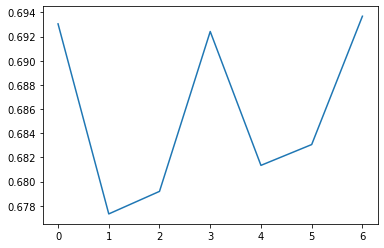

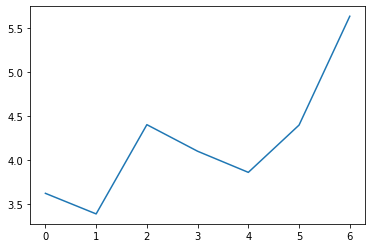

In [31]:
history_slow = network.fit_generator(generator_t, epochs=epochs, callbacks=callbacks, steps_per_epoch=generator_t.steps,
                                    validation_data=generator_v, validation_steps=generator_v.steps,
                                    shuffle=True,use_multiprocessing=True,max_queue_size=40,workers=64,)

plt.plot(history_slow.history['val_acc'])
plt.show()
plt.plot(history_slow.history['val_loss'])
plt.show()

---

## Scoring

### Apply model to training and validation data

In [32]:
generator_t.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions_t = network.predict_generator(generator_t, steps=generator_t.steps, verbose=1,
                  use_multiprocessing=True,max_queue_size=40,workers=64,)
print(predictions_t.shape)

generator_v.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions_v = network.predict_generator(generator_v, steps=generator_v.steps, verbose=1,
                  use_multiprocessing=True,max_queue_size=40,workers=64,)
print(predictions_v.shape)

571/571 [==============================] - 15s 27ms/step
(73026, 3)
273/273 [==============================] - 13s 46ms/step
(34865, 3)


In [33]:
Yhat_t = predictions_t.argmax(axis=-1)
print(Yhat_t.shape)
Yhat_v = predictions_v.argmax(axis=-1)
print(Yhat_v.shape)

(73026,)
(34865,)


### Extract corresponding _actual_ ground-truth values directly from catalog

In [34]:
Y_t = generator_t.get_label_series().values
print(Y_t.shape)
Y_v = generator_v.get_label_series().values
print(Y_v.shape)

(73026,)
(34865,)


### Generate typical scoring information

In [36]:
print("evaluate training")
# hardcoded categories
categories=[0,1,2]
train_confusion = util_scoring.calc_confusion(Yhat_t,Y_t,categories)
train_recalls, train_precisions, train_accuracy = util_scoring.calc_confusion_details(train_confusion)

# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = train_f_score[0] 
train_f_score_nonres = train_f_score[1]  
train_f_score_res = train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)

evaluate training
0 35976
1 6520
2 30530
[[31200   507  4269]
 [  182  5942   396]
 [  667   311 29552]]
73026 66694 0.9132911565743708


In [37]:
print ("evaluate validation")
valid_confusion = util_scoring.calc_confusion(Yhat_v,Y_v,categories)
valid_recalls, valid_precisions, valid_accuracy = util_scoring.calc_confusion_details(valid_confusion)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = valid_f_score[0] 
valid_f_score_nonres = valid_f_score[1] 
valid_f_score_res = valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)

evaluate validation
0 19104
1 5395
2 10366
[[14759   643  3702]
 [ 1537   723  3135]
 [ 1433   230  8703]]
34865 24185 0.6936756059085042


In [38]:
# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],train_recalls[1],train_recalls[2],None]
valid_recalls_expanded = [valid_recalls[0],valid_recalls[1],valid_recalls[2],None]
train_precisions_expanded = [train_precisions[0],train_precisions[1],train_precisions[2],None]
valid_precisions_expanded = [valid_precisions[0],valid_precisions[1],valid_precisions[2],None]

### Record experiment configuration and results

In [40]:
#scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
place_locales_filename = data_root+'models/'+model_id+'_place_locales.pkl'
category_weights_filename = data_root+'models/'+model_id+'_category_weights.pkl'
network_filename = data_root+'models/'+model_id+'.hd5'

if os.path.exists(network_filename):
    print('Aborting all pickle operations: file already exists at specified path ('+network_filename+')')
elif os.path.exists(category_weights_filename):
    print ('Aborting all pickle operations: file already exists at specified path ('+category_weights_filename+')')
else:
    print (network_filename)
    pickle.dump(place_locales, open(place_locales_filename, 'wb'))
    pickle.dump(category_weights, open(category_weights_filename, 'wb'))
    network.save(network_filename)
    # tracking only occurs if all saves are successful
    util_scoring.record_model_creation(
        model_id, notes, place_images, label_suffix+label_lot, resolution, stack_label, feature_count, 
        window, generator_t.remapping, balancing, 
        network.get_config(), epochs, batch_size,
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)


/data/phase_iv/models/3cat_hyd_test.hd5
model scorecard updated


---